In [1]:
import os
import json
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
import pickle

In [6]:
def collect_run_data(trade_name, base_dir="orbit_training_runs"):
    """
    Collect validation losses and parameters from all runs for a given trade_name.
    
    Args:
        trade_name (str): Name of the trade/experiment group.
        base_dir (str): Base directory containing run outputs.
    
    Returns:
        dict: Mapping of (n_bins, coordinate_system) to list of (val_losses, params).
    """
    trade_dir = os.path.join(base_dir, trade_name)
    if not os.path.exists(trade_dir):
        raise FileNotFoundError(f"Directory {trade_dir} does not exist.")
    
    run_data = defaultdict(list)
    
    for run_name in os.listdir(trade_dir):
        print(run_name)

        run_path = os.path.join(trade_dir, run_name)
        if not os.path.isdir(run_path):
            print("boo 1")
            continue
        
        # Load metrics.json
        sub_dir = [x for x in os.listdir(run_path) if "." not in x][0]
        metrics_path = os.path.join(run_path, sub_dir, "metrics.json")
        summary_path = os.path.join(run_path, "summary.json")
        
        if not (os.path.exists(metrics_path) and os.path.exists(summary_path)):
            print("boo 2")
            continue
        
        try:
            with open(metrics_path, 'r') as f:
                metrics = json.load(f)
            with open(summary_path, 'r') as f:
                summary = json.load(f)
            
            val_losses = metrics.get("val_losses", [])
            params = summary.get("args", {})
            
            n_bins = params.get("n_bins")
            coord_sys = params.get("coordinate_system")
            
            if n_bins is None or coord_sys is None or not val_losses:
                print("boo 3")
                continue
            
            run_data[(n_bins, coord_sys)].append((val_losses, params))
        
        except Exception as e:
            print(f"Error processing run {run_path}: {e}")
            continue
    
    return run_data

In [7]:
trade_name = "scaling_laws_v1"
run_data = collect_run_data(trade_name)        

.DS_Store
boo 1
learning_rate0.001_batch_size64_n_layers4_n_heads4_input_length32_dataset_size500_n_bins512_coordinate_systemcartesian_d_model256_d_ff1024
learning_rate1e-05_batch_size32_n_layers4_n_heads4_input_length32_dataset_size100_n_bins8192_coordinate_systemspherical_d_model256_d_ff1024
boo 2


In [8]:
pickle_dir = os.path.join(".", "orbit_training_runs", "scaling_laws_v1")

loaded_run_data = {}
for f in os.listdir(pickle_dir):
    if not f.endswith(".pickle"):
        continue
    pickle_path = os.path.join(pickle_dir, f)
    with open(pickle_path, "rb") as p:
        pickle_dict = pickle.load(p)
    for k, v in pickle_dict.items():
        if k not in loaded_run_data:
            loaded_run_data[k] = []
        loaded_run_data[k].extend(v)

In [9]:
loaded_run_data

{(512,
  'spherical'): [([0.8977806928426489,
    0.5946682564212944,
    0.4732905754349184,
    0.40862607593578776,
    0.3675898057681494,
    0.3419509953340652,
    0.32070457390089546,
    0.30512739165074276,
    0.2970910983285681,
    0.2853283383382646],
   {'trade_name': 'scaling_laws_v1',
    'learning_rate': 0.0001,
    'batch_size': 64,
    'n_layers': 4,
    'n_heads': 4,
    'input_length': 32,
    'dataset_size': 5000,
    'n_bins': 512,
    'coordinate_system': 'spherical',
    'd_model': 256,
    'd_ff': 1024,
    'epochs': 10}), ([5.630192480708912,
    5.626754793150436,
    5.624463699011811,
    5.623164272270445,
    5.622658974226026,
    5.622640516685947,
    5.621646441412654,
    5.62120369886935,
    5.621537560120296,
    5.62117322412318],
   {'trade_name': 'scaling_laws_v1',
    'learning_rate': 0.001,
    'batch_size': 64,
    'n_layers': 6,
    'n_heads': 8,
    'input_length': 32,
    'dataset_size': 500,
    'n_bins': 512,
    'coordinate_system': 

In [8]:
run_data

defaultdict(list,
            {(512,
              'cartesian'): [([1.1253978016835138,
                0.9054382007527617,
                0.7890979347362617,
                0.7115412151680842,
                0.6647634865606532,
                0.6202448258836811,
                0.5901901790182238,
                0.5670764890095198,
                5.362951767463563,
                5.225292611956028],
               {'trade_name': 'scaling_laws_v1',
                'learning_rate': 0.001,
                'batch_size': 64,
                'n_layers': 4,
                'n_heads': 4,
                'input_length': 32,
                'dataset_size': 500,
                'n_bins': 512,
                'coordinate_system': 'cartesian',
                'd_model': 256,
                'd_ff': 1024,
                'epochs': 10})]})

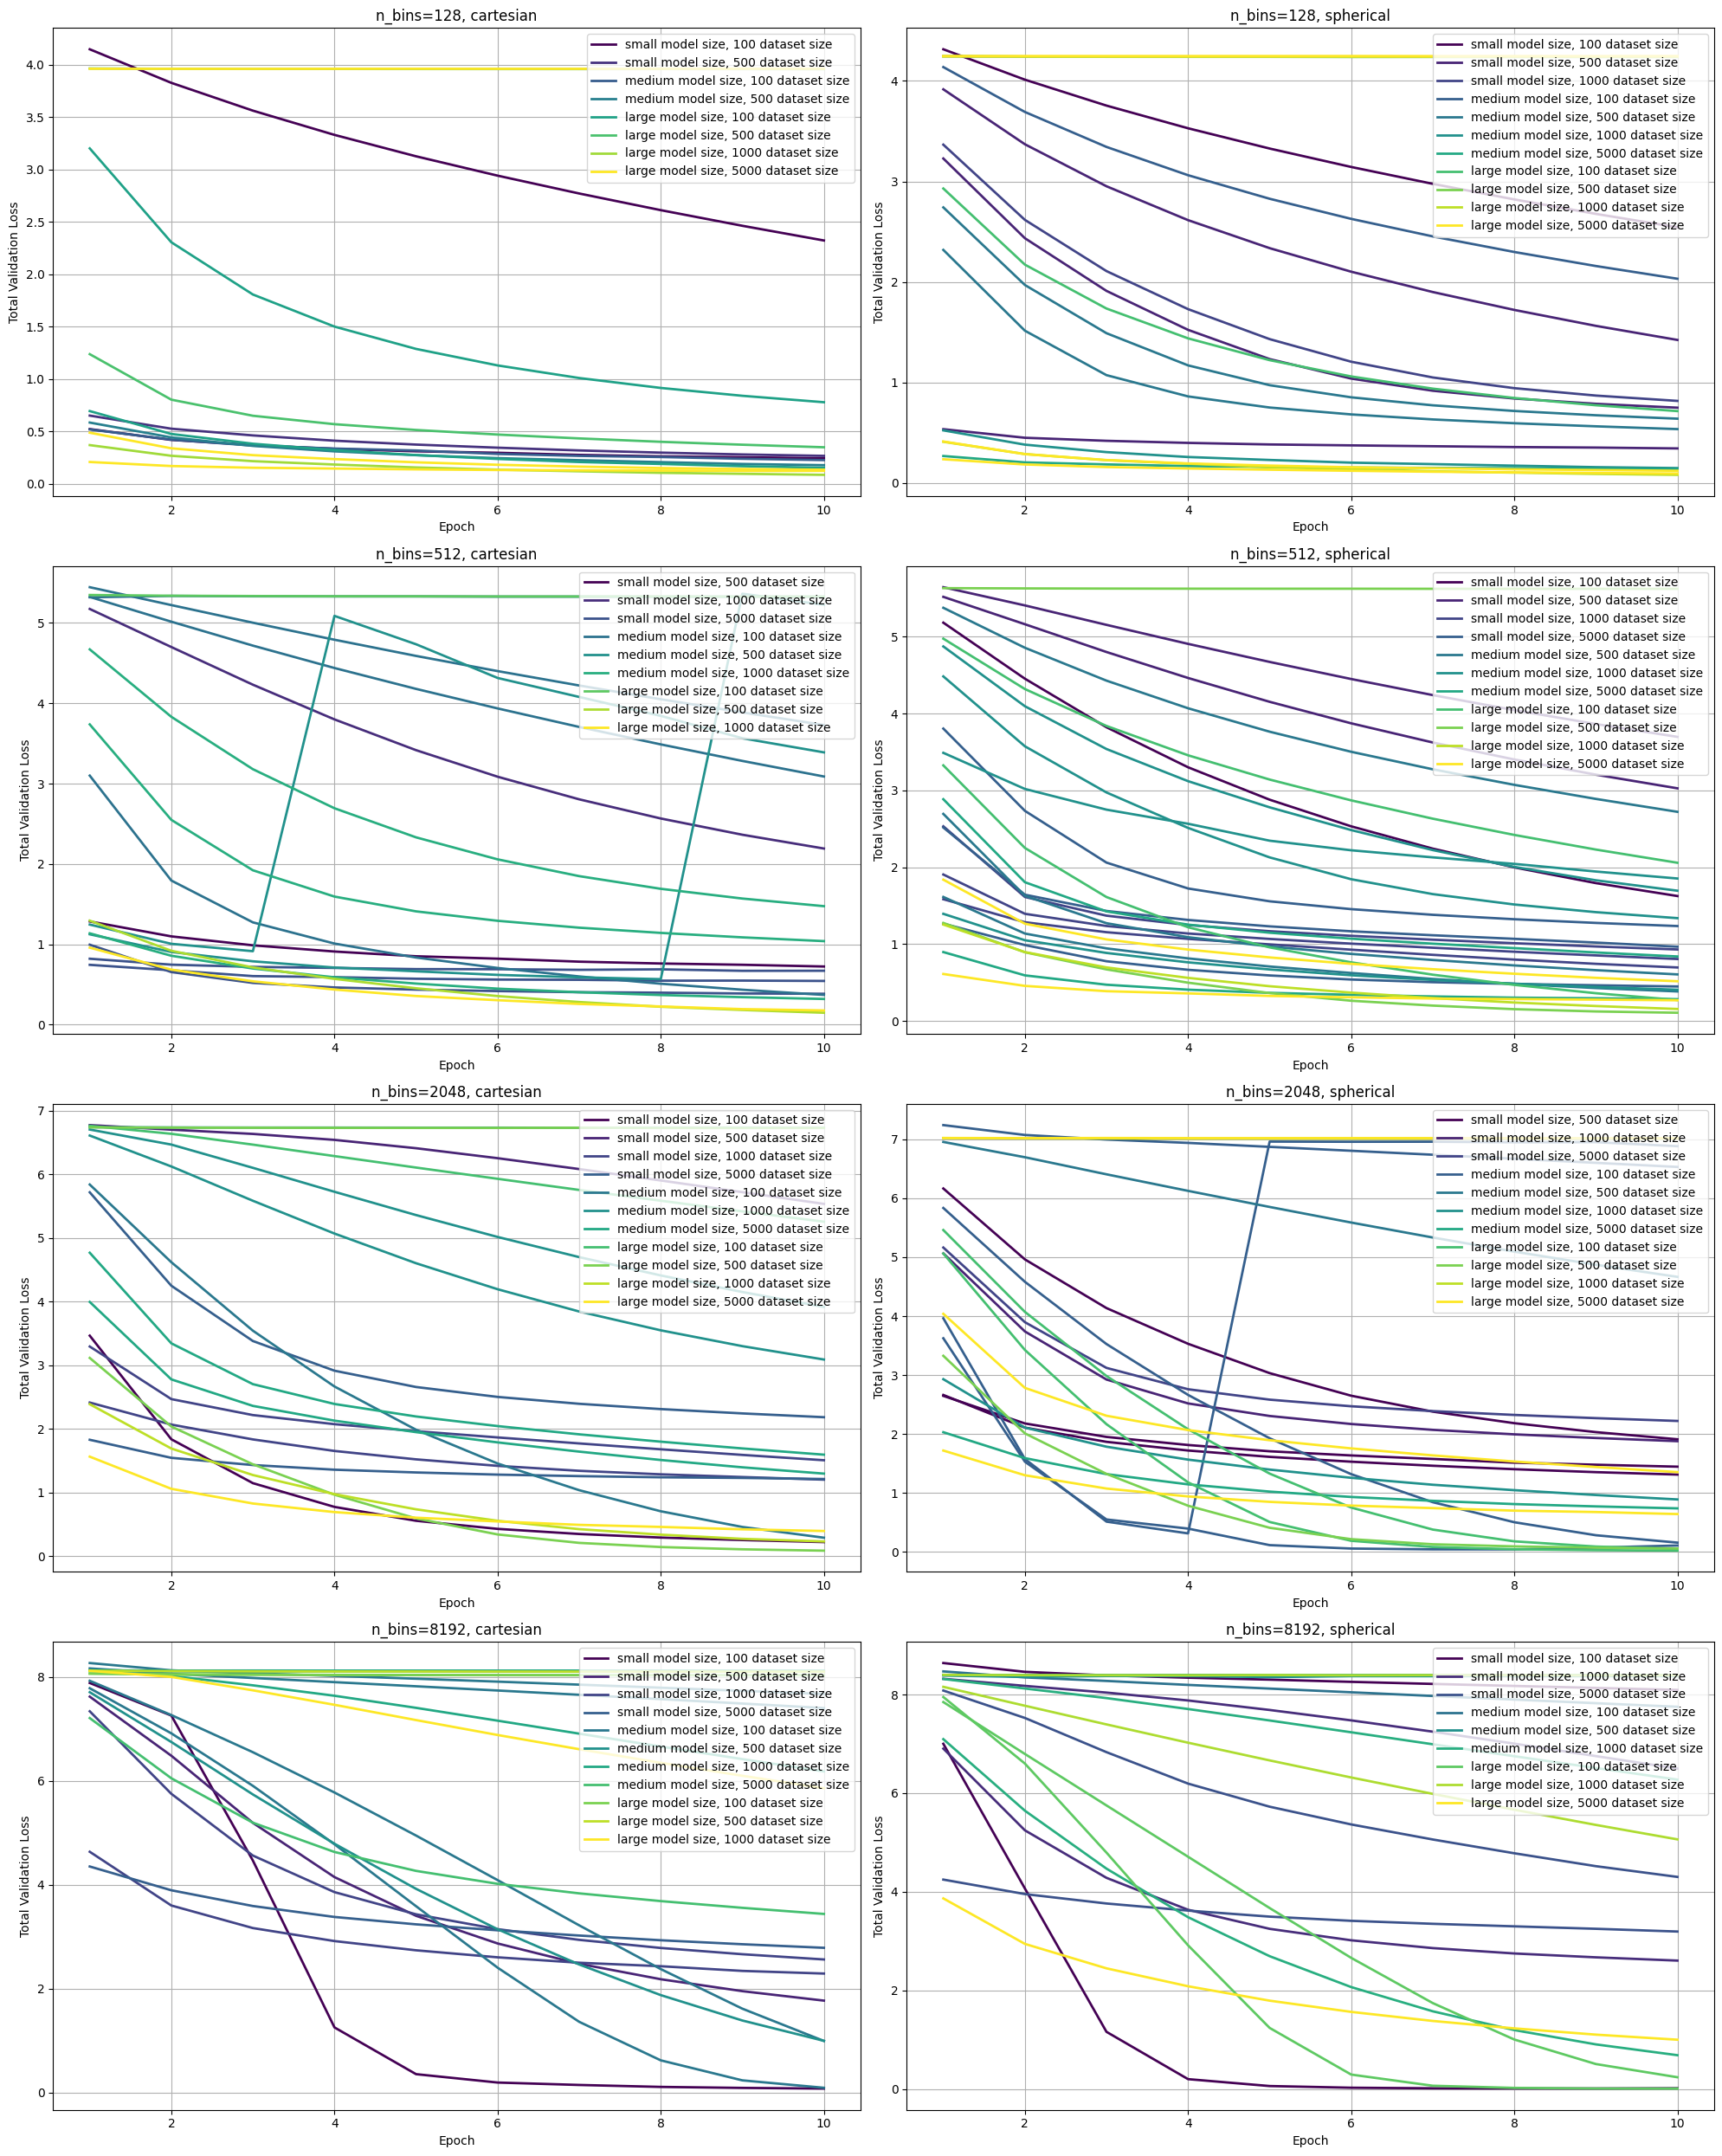

In [33]:
# Determine the number of subplots needed
combinations = sorted(loaded_run_data.keys())  # Sort for consistent ordering
n_plots = len(combinations)

# Calculate grid size (e.g., aim for a roughly square grid)
n_cols = int(np.ceil(np.sqrt(n_plots)))
n_rows = int(np.ceil(n_plots / n_cols))

# Create a single figure with subplots
# fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 10, n_rows * 9), squeeze=False)
fig, axes = plt.subplots(4, 2, figsize=(20, 25), squeeze=False)
axes = axes.flatten()  # Flatten to easily index axes

for idx, (n_bins, coord_sys) in enumerate(combinations):
    ax = axes[idx]
    runs = loaded_run_data[(n_bins, coord_sys)]

    unique_bois = []
    for (val_losses, params) in runs:
        epochs = list(range(1, len(val_losses) + 1))
        
        # legend_label = (
        #     f"n_layers={params['n_layers']}, "
        #     f"n_heads={params['n_heads']}, "
        #     f"d_model={params['d_model']}, "
        #     f"d_ff={params['d_ff']}, "
        #     f"dataset_size={params['dataset_size']}, "
        #     f"lr={params['learning_rate']}, "
        #     f"batch_size={params['batch_size']}"
        # )
        
        legend_label = ""
        if params['n_layers'] == 2:
            legend_label = "small"
        elif params['n_layers'] == 4:
            legend_label = "medium"
        elif params['n_layers'] == 6:
            legend_label = "large"

        legend_label += f" model size, {params['dataset_size']} dataset size"

        unique_boi = (epochs, val_losses, legend_label)
        unique_bois.append(unique_boi)

        # ax.plot(epochs, val_losses, label=legend_label, linewidth=2)

    label_to_color = {}
    colors = plt.cm.viridis(np.linspace(0, 1, len(set(label for _, _, label in sorted(unique_bois, key=lambda x: (x[2].split(" ")[0], -int(x[2].split(" ")[3])), reverse=True)))))  # Generate distinct colors

    # Assign colors to unique labels
    for i, (_, _, legend_label) in enumerate(sorted(unique_bois, key=lambda x: (x[2].split(" ")[0], -int(x[2].split(" ")[3])), reverse=True)):
        if legend_label not in label_to_color:
            label_to_color[legend_label] = colors[len(label_to_color) % len(colors)]

    # Plot lines, only assign label for the first occurrence of each legend_label
    plotted_labels = set()
    for (epochs, val_losses, legend_label) in sorted(unique_bois, key=lambda x: (x[2].split(" ")[0], -int(x[2].split(" ")[3])), reverse=True):
        if legend_label not in plotted_labels:
            # Plot with label for the first occurrence
            ax.plot(epochs, val_losses, label=legend_label, color=label_to_color[legend_label], linewidth=2)
            plotted_labels.add(legend_label)
        else:
            # Plot without label for subsequent occurrences
            ax.plot(epochs, val_losses, color=label_to_color[legend_label], linewidth=2)

    # for (epochs, val_losses, legend_label) in sorted(unique_bois, key=lambda x: x[2], reverse=True):
    #     ax.plot(epochs, val_losses, label=legend_label, linewidth=2)    

    ax.set_xlabel("Epoch")
    ax.set_ylabel("Total Validation Loss")
    ax.set_title(f"n_bins={n_bins}, {coord_sys}")
    ax.grid(True)
    
    ax.legend(loc="upper right")

    # Place legend outside the plot
    # ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)

    # ax.legend(bbox_to_anchor=(0.5, -0.2), loc='upper center', fontsize=8, 
    #             ncol=2, borderaxespad=0.)

for idx in range(len(combinations), len(axes)):
    axes[idx].set_visible(False)



# fig.suptitle(f"Validation Loss vs Epochs for {trade_name}", fontsize=16, y=1.02)

plt.tight_layout()

# Adjust layout to prevent overlap, leaving space for legends
# plt.tight_layout(rect=[0, 0.1, 1, 0.95])  # Leave bottom space for legends

plt.show()